In [1]:
#general
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,4)
import pandas as pd
pd.set_option('display.max_columns', 50)

#preprocessing
from datetime import datetime, timedelta
import category_encoders as ce

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#model validation / evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Model Evaluation Functions

In [2]:
def cm2df(cm, labels): 
    """converts a numpy array confusion matrix to a pandas dataframe, with class labels"""
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

def model_eval(y_test, y_pred): 
    """prints out a confusion matrix (pandas dataframe) and classification report"""
    conf_mat = confusion_matrix(y_test, y_pred)
    cm_as_df=cm2df(conf_mat,[0,1])
    new_names = {0:'Order Fail',1:'Order Success'}
    cm_as_df = cm_as_df.rename(index=new_names, 
                                 columns=new_names)
    print('\n')
    print('CONFUSION MATRIX (predicted along top, actual along side): ')
    display(cm_as_df)

    print('\n')
    print(classification_report(y_test,y_pred,target_names=['Order Fail','Order Success']))
    
def cross_validation(model, features, response, num_folds):
    metrics = ['precision_macro', 'recall_macro', "f1_macro"]
    cv = cross_validate(model, features, response, scoring=metrics, cv=num_folds)
    print("Test data set average precision across 5 folds:")
    print(cv['test_precision_macro'])
    print("\nTest data set average recall across 5 folds:")
    print(cv['test_recall_macro'])
    print("\nTest data set average fscore across 5 folds:")
    print(cv['test_f1_macro'])
    
def plot_roc_curve(model, X_test, y_test):
    probabilities = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probabilities)
    print('AUC: %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    # plot no skill curve
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [3]:
df = pd.read_csv('data.csv')
# display(df.describe())
display(df.head())

,symbol,tradedate,starttime,side,size,strategyphase,venue,venuetype,ordertype,peginstruction,tif,minexecqty,limitprice,prevailbid,prevailask,prevailbidsize,prevailasksize,dispatcherrebalance,lotsize,securitycategory,sector,mktcap,adv20d,averagespread,misbin,misavgbidsize1min,misavgasksize1min,misavgspread1min,misoddlotvolume1min,misadfvolume1min,misvolume1min,lastordersuccess,lastorderfullsuccess,lastorderduration,lastfillduration,ordersuccess
0,C02112214394819,20180914,10:22:03.668,Sell,600,PingDarkTouch,BARX,Dark,LIMIT,NONE,IOC,0,5.78,5.78,5.82,200,200,0,100,COMMON,Energy,SMALL,0.0,0.033333,10:22:00,176,316,0.045597,373,1227,2100,0.0,0.0,862392.0,NaN,0
1,C02112214394819,20180914,10:22:03.668,Sell,500,PingDarkTouch,CICX,Dark,LIMIT,NONE,IOC,0,5.78,5.78,5.82,200,200,0,100,COMMON,Energy,SMALL,0.0,0.033333,10:22:00,176,316,0.045597,373,1227,2100,0.0,0.0,862392.0,NaN,0
2,C102221371819,20180914,10:07:16.012,Sell,100,PingDarkPxImp,UBSA,Dark,LIMIT,MID,IOC,0,22.20,22.20,22.23,500,1700,0,100,FUND,NaN,SMALL,0.0,0.037368,10:07:00,631,1767,0.028370,0,0,200,0.0,0.0,361595.0,NaN,0
3,C02112214394819,20180914,10:22:03.668,Sell,500,PingDarkTouch,JPMX,Dark,LIMIT,NONE,IOC,0,5.78,5.78,5.82,200,200,0,100,COMMON,Energy,SMALL,0.0,0.033333,10:22:00,176,316,0.045597,373,1227,2100,0.0,0.0,862392.0,NaN,0
4,C102221371819,20180914,10:07:16.013,Sell,200,PingDarkTouch,JSES,Single-Dealer,LIMIT,NONE,IOC,0,22.20,22.20,22.23,500,1700,0,100,FUND,NaN,SMALL,0.0,0.037368,10:07:00,631,1767,0.028370,0,0,200,NaN,NaN,NaN,NaN,0


### Class Proportions (Response = 'ordersuccess')

In [4]:
success = df[df['ordersuccess']==1]
fail = df[df['ordersuccess']==0]

success_num = len(success)
fail_num = len(fail)
total = len(df)

print('Number of order successes: ', success_num)
print('Proportion of order successes: ', success_num / (success_num + fail_num))
print('Number of order failures: ', fail_num)
print('Proportion of order failures: ', fail_num / (success_num + fail_num))

Number of order successes:  28190
Proportion of order successes:  0.05021044213331149
Number of order failures:  533247
Proportion of order failures:  0.9497895578666885


## Preprocessing

In [5]:
def getTimeMS(t):
    if '.' in t:
        timestamp, ms = t.split('.')
    else:
        timestamp = t
        ms = 0
    time_obj = datetime.strptime(timestamp, '%H:%M:%S')
    epoch = datetime(1900, 1, 1, 0, 0, 0, 0)
    milliseconds = (time_obj - epoch) // timedelta(milliseconds=1)
    return milliseconds + float(ms)*1000

df['time_ms'] = df['starttime'].apply(lambda x: getTimeMS(x))


#continuous features
cont_features = df.loc[:,['time_ms','size','minexecqty','limitprice','prevailbid','prevailask','prevailbidsize','prevailasksize',
                          'dispatcherrebalance','lotsize','averagespread','misavgbidsize1min','misavgasksize1min', 
                          'misavgspread1min', 'misoddlotvolume1min', 'misadfvolume1min','misvolume1min']]

#one-hot encoded features
dummies = pd.get_dummies(df.loc[:,['side','venuetype','securitycategory', 'peginstruction',
                                   'sector','mktcap']].astype('category'),drop_first=True)

#binary encoded features
enc = ce.BinaryEncoder()
binary_sym = enc.fit_transform(df.loc[:,'symbol'].as_matrix())
names = {'0_0':'symbol_0', '0_1':'symbol_1','0_2':'symbol_2','0_3':'symbol_3','0_4':'symbol_4',
         '0_5':'symbol_5','0_6':'symbol_6','0_7':'symbol_7','0_8':'symbol_8','0_9':'symbol_9',
         '0_10':'symbol_10','0_11':'symbol_11','0_12':'symbol_12'}
binary_sym = binary_sym.rename(columns=names)

binary_venue = enc.fit_transform(df.loc[:,'venue'].as_matrix())
names = {'0_0':'venue_0', '0_1':'venue_1','0_2':'venue_2',
         '0_3':'venue_3','0_4':'venue_4','0_5':'venue_5','0_6':'venue_6'}
binary_venue = binary_venue.rename(columns=names)


adv20d = df.loc[:,'adv20d'].fillna(0)


features = pd.concat([adv20d, cont_features, dummies, binary_sym, binary_venue], axis=1)
response = df.loc[:,'ordersuccess']

df = pd.concat([features,response],axis=1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Train / Test Split

In [6]:
df = df.sample(frac=1)
train = df.head(round(total*.70))
train = train.reset_index(drop=True)
test = df.tail(round(total*.30))
test = test.reset_index(drop=True)

train_success = train[train['ordersuccess']==1]
train_fail = train[train['ordersuccess']==0]

test_success = test[test['ordersuccess']==1]
test_fail = test[test['ordersuccess']==0]

## Model Iterations

In [7]:
def train_model(train_fail, train_success):
    downsampled_fails = train_fail.sample(n=len(train_success))

    #recombine and shuffle data
    train_downsampled = pd.concat([downsampled_fails, train_success],axis=0)
    train_downsampled = train_downsampled.sample(frac=1).reset_index(drop=True)
    
    #split into x and y
    train_features = train_downsampled.loc[:,train_downsampled.columns != 'ordersuccess']
    train_response = train_downsampled.loc[:,'ordersuccess']
    
    #train model
    #tune parameters
    RF = RandomForestClassifier()
    RF.fit(train_features, train_response)
    return RF


train_features = train.loc[:,train.columns != 'ordersuccess']
test_features = test.loc[:,test.columns != 'ordersuccess']
test_features = test_features.reset_index(drop=True)


#write code to keep track of how many rows are covered
new_features_train = pd.DataFrame({})
new_features_test = pd.DataFrame({})
for i in range(0, 50):
    model = train_model(train_fail, train_success)
    y_pred_train = pd.DataFrame(model.predict(train_features))
    y_pred_train = y_pred_train.rename(columns={0:"Model %s" %i})
    new_features_train = pd.concat([new_features_train, y_pred_train], axis=1)
    
    y_pred_test = pd.DataFrame(model.predict(test_features))
    y_pred_test = y_pred_test.rename(columns={0:"Model %s" %i})
    new_features_test = pd.concat([new_features_test, y_pred_test], axis=1)
    
    
train_features = pd.concat([train_features, new_features_train], axis=1)
test_features = pd.concat([test_features, new_features_test], axis=1)

display(train_features.head())
display(test_features.head())

train_response = train.loc[:,'ordersuccess']
test_response = test.loc[:,'ordersuccess']
test_response = test_response.reset_index(drop=True)

#dataframes to store only the model prediction columns
train_model_pred = train_features.iloc[:,67:]
test_model_pred = test_features.iloc[:,67:]

,adv20d,time_ms,size,minexecqty,limitprice,prevailbid,prevailask,prevailbidsize,prevailasksize,dispatcherrebalance,lotsize,averagespread,misavgbidsize1min,misavgasksize1min,misavgspread1min,misoddlotvolume1min,misadfvolume1min,misvolume1min,side_Sell,venuetype_Dark,venuetype_Gray,venuetype_Single-Dealer,securitycategory_COMMON,securitycategory_ETF,securitycategory_FUND,...,Model 25,Model 26,Model 27,Model 28,Model 29,Model 30,Model 31,Model 32,Model 33,Model 34,Model 35,Model 36,Model 37,Model 38,Model 39,Model 40,Model 41,Model 42,Model 43,Model 44,Model 45,Model 46,Model 47,Model 48,Model 49
0,100000.0,38546000.0,100,100,212.59,212.43,212.59,300,200,0,100,0.373125,256,173,0.159073,87,500,687,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000000.0,38561000.0,1000,100,6.32,6.32,6.34,1000,300,0,100,0.012632,522,729,0.012994,100,3026,15226,1,0,0,1,0,0,0,...,1,0,1,1,1,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1,1,1,1,0
2,1500000.0,36942000.0,100,0,152.43,152.33,152.43,100,100,0,100,0.070588,474,295,0.119693,428,471,1714,0,0,1,0,1,0,0,...,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,700000.0,38886000.0,17000,500,2.50,2.49,2.50,3400,1300,0,100,0.010000,3221,1250,0.010000,0,0,100,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,500000.0,37000000.0,400,0,76.67,76.58,76.67,200,100,0,100,0.061667,178,131,0.089305,3,1400,2103,0,0,1,0,1,0,0,...,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


,adv20d,time_ms,size,minexecqty,limitprice,prevailbid,prevailask,prevailbidsize,prevailasksize,dispatcherrebalance,lotsize,averagespread,misavgbidsize1min,misavgasksize1min,misavgspread1min,misoddlotvolume1min,misadfvolume1min,misvolume1min,side_Sell,venuetype_Dark,venuetype_Gray,venuetype_Single-Dealer,securitycategory_COMMON,securitycategory_ETF,securitycategory_FUND,...,Model 25,Model 26,Model 27,Model 28,Model 29,Model 30,Model 31,Model 32,Model 33,Model 34,Model 35,Model 36,Model 37,Model 38,Model 39,Model 40,Model 41,Model 42,Model 43,Model 44,Model 45,Model 46,Model 47,Model 48,Model 49
0,100000.0,37109000.0,700,0,4.43,4.43,4.44,3900,900,0,100,0.010000,3982,800,0.01,8,408,408,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,38227000.0,2500,100,18.52,18.52,19.01,200,900,0,100,0.235625,200,600,0.49,1,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100000.0,37888000.0,1500,100,16.70,16.70,16.72,1000,900,0,100,0.017895,1049,679,0.02,0,1700,1800,1,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,300000.0,39244000.0,400,200,9.56,9.55,9.56,1400,1700,0,100,0.010000,1451,1700,0.01,0,0,100,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,37550000.0,300,100,25.06,25.06,25.15,1000,300,0,100,0.127778,1000,300,0.09,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Random Forest Feature Selection

In [11]:
RF = RandomForestClassifier()
RF.fit(train_model_pred, train_response)
# y_pred = RF.predict(test_model_pred)

# model_eval(test_response, y_pred)

# plot_roc_curve(RF, test_model_pred, test_response)
# cross_validation(RF, features, response, 5)

#select top n features
important_features = sorted(zip(map(lambda x: round(x, 4), RF.feature_importances_), 
                                train_model_pred.columns), reverse=True)[0:10]
print(important_features)

[(0.1121, 'Model 3'), (0.0912, 'Model 1'), (0.0657, 'Model 26'), (0.0554, 'Model 14'), (0.0459, 'Model 39'), (0.0415, 'Model 2'), (0.0338, 'Model 43'), (0.0332, 'Model 27'), (0.029, 'Model 42'), (0.0269, 'Model 20')]


## Logistic Regression



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,156009,3994
Order Success,4152,4276




               precision    recall  f1-score   support

   Order Fail       0.97      0.98      0.97    160003
Order Success       0.52      0.51      0.51      8428

  avg / total       0.95      0.95      0.95    168431

AUC: 0.939


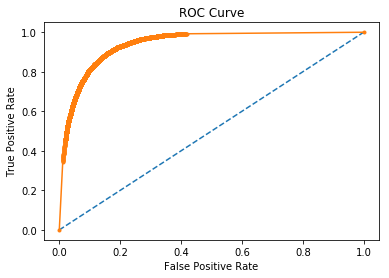

In [21]:
logreg = LogisticRegression()
logreg.fit(train_model_pred, train_response)

y_pred = logreg.predict(test_model_pred)
model_eval(test_response, y_pred)

plot_roc_curve(logreg, test_model_pred, test_response)
# cross_validation(logreg, features, response, 5)

## Linear SVC



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,155853,4150
Order Success,4078,4350




               precision    recall  f1-score   support

   Order Fail       0.97      0.97      0.97    160003
Order Success       0.51      0.52      0.51      8428

  avg / total       0.95      0.95      0.95    168431

AUC: 0.939


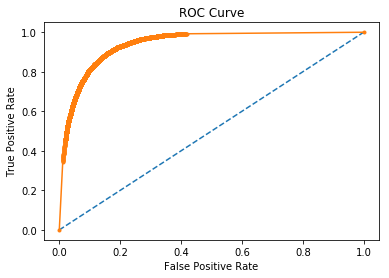

In [18]:
clf = svm.LinearSVC().fit(train_model_pred, train_response) #linear kernel function
y_pred = clf.predict(test_model_pred)

model_eval(test_response, y_pred)

plot_roc_curve(logreg, test_model_pred, test_response)
# cross_validation(logreg, features, response, 5)

## Linear SVC with Feature Selection

In [19]:
names = []
for i in important_features:
    names.append(i[1])
    
clf = svm.LinearSVC().fit(train_model_pred.loc[:, names], train_response) #linear kernel function
y_pred = clf.predict(test_model_pred.loc[:, names])
model_eval(test_response, y_pred)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,154383,5620
Order Success,3881,4547




               precision    recall  f1-score   support

   Order Fail       0.98      0.96      0.97    160003
Order Success       0.45      0.54      0.49      8428

  avg / total       0.95      0.94      0.95    168431



## Neural Net (sklearn)

Iteration 1, loss = 0.05127118
Iteration 2, loss = 0.03491102
Iteration 3, loss = 0.03267015
Iteration 4, loss = 0.03363168
Iteration 5, loss = 0.03341989
Iteration 6, loss = 0.03269780
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.


CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,155525,4478
Order Success,3929,4499




               precision    recall  f1-score   support

   Order Fail       0.98      0.97      0.97    160003
Order Success       0.50      0.53      0.52      8428

  avg / total       0.95      0.95      0.95    168431

AUC: 0.939


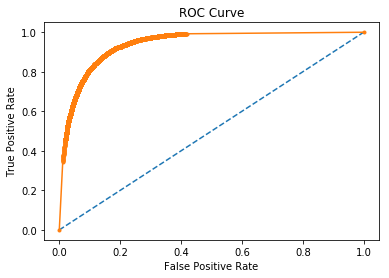

In [25]:
clfANN = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
           beta_1=0.95, beta_2=0.9995, early_stopping=False,
           epsilon=1e-05, hidden_layer_sizes=(100, 100),
           learning_rate='constant', learning_rate_init=0.01,
           max_iter=3000, momentum=0.9,
           nesterovs_momentum=True, power_t=0.5, random_state=0,
           shuffle=True, solver='adam', tol=0.001,
           validation_fraction=0.1, verbose=True, warm_start=False)


clfANN.fit(train_model_pred, train_response)
y_pred = clfANN.predict(test_model_pred)
# y_pred = (clfANN.predict_proba(test_model_pred)[:,1] >= 0.1).astype(bool) #adjust classification threshold

model_eval(test_response, y_pred)
plot_roc_curve(clfANN, test_model_pred, test_response)
# cross_validation(clfANN, features, response, 5)